# Softmax回归

#### · 一般而言，回归解决的是连续型数值输出，输出是一个单一数值
#### · 而分类问题通常包含多个输出，且输出是离散型的

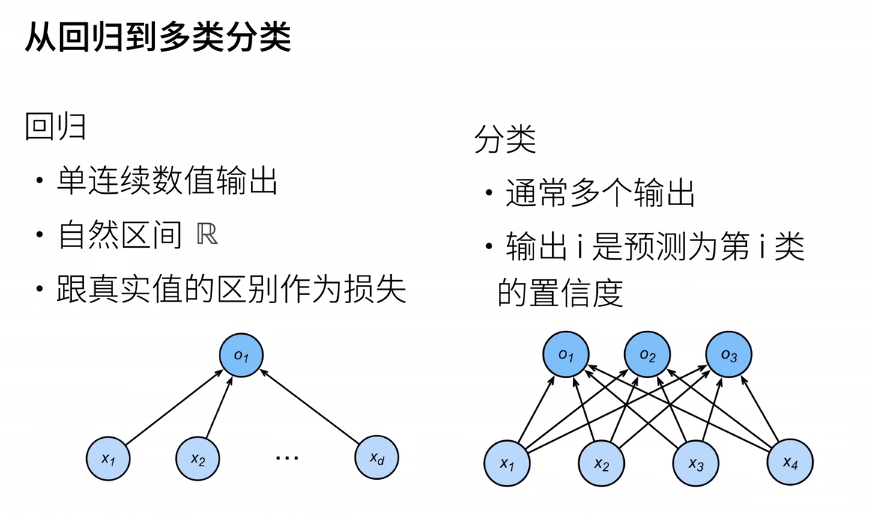

#### · 对于softmax回归，同样还是使用均方损失进行估计
#### · 对于类别，使用一位数据进行编码。$\mathbf {y} = [y_1, y_2, ..., y_n]^T$
#### · $y_i = \begin{cases}
1 & if \space  i = y\\
0 & otherwise
\end{cases}$
#### · 模型使用最大值作为预测，即$\hat y = \underset{i}{argmax} o_i$

#### · 在实际分类的过程中，其实并不关心真正的值是什么。
#### · 真正关注的，应该是要使得正确那一类的值足够大
#### · 即，$o_y - o_i \geq \Delta(y, i)$

#### · 使用softmax函数，作用于$\mathbf o$上
#### · $\mathbf {\hat y} = softmax(\mathbf o)$
#### · softmax函数定义为：$$\hat y_k = \frac {e^{o_i}}{\sum_k e^{o_k}}$$
#### · 这样一个形式，严格保证了每一个样本的概率是大于零的，且均在0~1之间

# 损失函数
## · 使用了交叉熵(cross-entropy)作为损失函数
### · 弄懂交叉熵之前，得先知道熵的概念是什么
#### · 熵是一个信息论中的概念，它的意义在于衡量系统的不确定性/包含信息量的多少
#### · 熵的一个前置概念是：信息量
#### · 信息量的定义是：$f:=-logp$
#### · 如果一件事情发生的概率很低，并且最后发生了，那么包含的信息量就是大的
#### · 根据这个思想，香农定义出了信息量的定义式
#### · 为了衡量系统的不确定性，熵引入了信息量这一概念
#### · 如果一个事情他的不确定性很高，说明他的信息量就很大；但虽然他的信息量很大，但是它发生的概率也很低，所以说应该要用它自身的概率来对信息量进行修正
#### · 所以说，熵就被定义为：$c_e = \sum_{k}-p_klogp_k$
#### · 熵是对于同一个概率系统内部的信息量的衡量

## · 相对熵（KL散度）
#### · 要衡量两个概率系统之间的信息量的差别，可以使用相对熵作为衡量标准
#### · 定义式：$$\begin{aligned}
           \mathbf D_{KL}(P||Q)
            &:=\sum^m_{i=1}p_i·(f_Q(q_i)-f_P(p_i))\\
           & = \sum^m_{i=1}p_i·((-log_2q_i)-(-log_2p_i))\\
           & = \sum^m_{i=1}p_i·(-log_2q_i)-\sum^m_{i=1}p_i·(-log_2p_i)\\
           &[第一个求和符号是交叉熵，第二个求和符号是系统内的熵]
            \end{aligned}$$
#### · 根据吉布斯不等式，KL散度一定是大于零的

# 1 图像分类数据集
#### MNIST数据集是图像分类中广泛使用的数据集之一，但是太简单了。现在用更复杂的Fashion-MNIST数据集

In [5]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()### 用svg实现图片

#### 通过框架内的函数将Fashion-MNIST数据集下载并读取到内存中

In [13]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0～1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

Using downloaded and verified file: ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz
Extracting ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data\FashionMNIST\raw

Using downloaded and verified file: ../data\FashionMNIST\raw\train-labels-idx1-ubyte.gz
Extracting ../data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw

Using downloaded and verified file: ../data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz
Extracting ../data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100%|█████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<00:00, 2577566.79it/s]


Extracting ../data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



In [15]:
len(mnist_train), len(mnist_test), mnist_train[0][0].shape

(60000, 10000, torch.Size([1, 28, 28]))

In [20]:
def get_fashion_mnist_labels(labels):  
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5): 
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

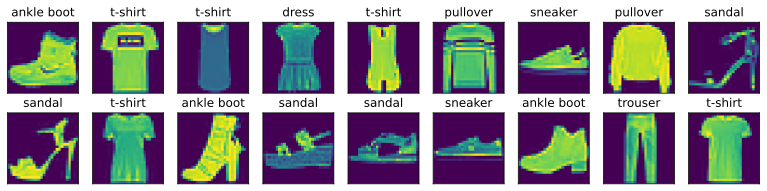

In [25]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

In [35]:
batch_size = 256

def get_dataloader_workers():  #@save
    """使用4个进程来读取数据"""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'38.29 sec'

In [28]:
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

#### 从零开始的softmax回归实现

In [36]:
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

#### 这一步的目的，是把图片展平，使之称成为一个维度为28*28=784的向量
#### 由于数据集有10个类别，因此，输出维度为10

In [65]:
num_inputs = 784
num_outputs = 10
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad = True)
b = torch.zeros(num_outputs, requires_grad=True)

In [38]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim = True)
    return X_exp / partition

In [40]:
X = torch.normal(0, 1, (3, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.1693, 0.2316, 0.1677, 0.2873, 0.1441],
         [0.1049, 0.3073, 0.0814, 0.2872, 0.2192],
         [0.1543, 0.1699, 0.4660, 0.1478, 0.0621]]),
 tensor([1., 1., 1.]))

#### 实现softmax回归

In [41]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b) 

#### 创建一个数据```y_hat```, 其中包含2个样本在3个类别的预测概率，使用```y```作为```y_hat```中概率的索引

In [44]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6],[0.2, 0.3, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

#### 实现交叉熵函数

In [49]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])
cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

#### 将预测类别与真实的y进行比较

In [52]:
def accuracy(y_hat, y):
    '''计算正确的样本数'''
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1: ### 样本数大于1，分类数大于1
        y_hat = y_hat.argmax(axis=1)### 按行求出最大值
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum()) 
accuracy(y_hat, y) / len(y)

0.5

In [57]:
class Accumulator:
    """创建n个变量，并分别对其累加"""
    def __init__(self, n):
        self.data = [0.0] * n
    
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    
    def reset(self):
        self.data = [0.0] * len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

#### 用于评估模型的准确率

In [83]:
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [66]:
evaluate_accuracy(net, test_iter)

0.1737

#### Softmax回归的训练

In [79]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [68]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

#### 开始训练

In [81]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

#### 小批量随机梯度下降

In [75]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

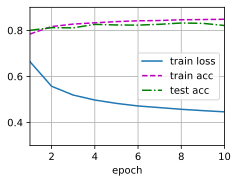

In [85]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

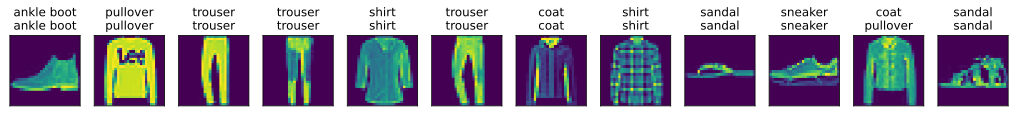

In [87]:
def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter, 12)

### Softmax回归的简洁实现

In [88]:
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [91]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std = 0.01)
    
net.apply(init_weights);

In [92]:
loss = nn.CrossEntropyLoss()

In [93]:
trainer = torch.optim.SGD(net.parameters(), lr = 0.1)

AssertionError: nan

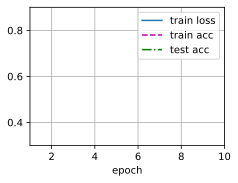

In [95]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)